In [93]:
from collections import defaultdict
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

import warnings; warnings.simplefilter('ignore')

In [94]:
data_df = pd.read_json('json_data/All_Beauty.json', lines=True)

In [95]:
data_df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,5,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,1,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN
3,5,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800,25,NaN
4,5,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000,3,NaN


In [96]:
data_df.shape

(5269, 12)

In [97]:
data_df.dtypes

overall            int64
verified            bool
reviewTime        object
reviewerID        object
asin              object
style             object
reviewerName      object
reviewText        object
summary           object
unixReviewTime     int64
vote              object
image             object
dtype: object

In [98]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5269 entries, 0 to 5268
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         5269 non-null   int64 
 1   verified        5269 non-null   bool  
 2   reviewTime      5269 non-null   object
 3   reviewerID      5269 non-null   object
 4   asin            5269 non-null   object
 5   style           4624 non-null   object
 6   reviewerName    5269 non-null   object
 7   reviewText      5264 non-null   object
 8   summary         5264 non-null   object
 9   unixReviewTime  5269 non-null   int64 
 10  vote            552 non-null    object
 11  image           98 non-null     object
dtypes: bool(1), int64(2), object(9)
memory usage: 458.1+ KB


In [99]:
print('Number of missing values across columns: \n',data_df.isnull().sum())

Number of missing values across columns: 
 overall              0
verified             0
reviewTime           0
reviewerID           0
asin                 0
style              645
reviewerName         0
reviewText           5
summary              5
unixReviewTime       0
vote              4717
image             5171
dtype: int64


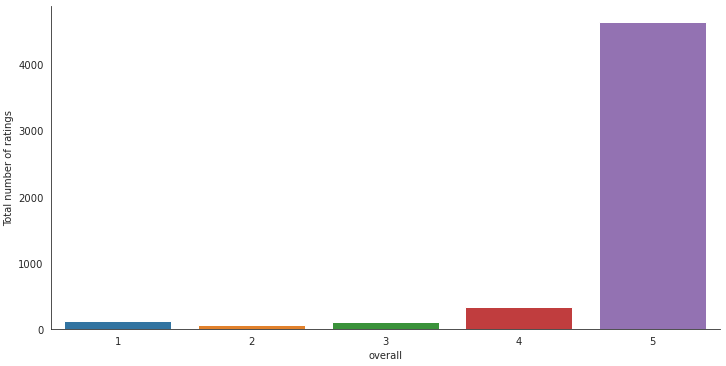

In [100]:
with sns.axes_style('white'):
    g = sns.factorplot("overall", data=data_df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [101]:
no_of_rated_products_per_user = data_df.groupby(by='asin')['overall'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

asin
B0012Y0ZG2    1794
B000URXP6E     858
B001OHV1H4     489
B00006L9LC     489
B0009RF9DW     392
Name: overall, dtype: int64

In [102]:
no_of_rated_products_per_user.describe()

count      85.000000
mean       61.988235
std       230.395390
min         1.000000
25%         2.000000
50%         6.000000
75%        13.000000
max      1794.000000
Name: overall, dtype: float64

In [103]:
##Collaborative Filtering
!pip install scikit-surprise
from surprise import KNNWithMeans
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import KFold
import os
from surprise.model_selection import train_test_split

You should consider upgrading via the '/Users/yashchhabria/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [104]:
reader = Reader(rating_scale=(1, 5))
new_df = data_df[['reviewerID','asin','overall']]
data = Dataset.load_from_df(new_df,reader)

In [105]:
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [106]:
# algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
# algo.fit(trainset)

In [107]:
algo = SVD()
algo.fit(trainset)

In [108]:
test_pred = algo.test(testset)

## Calculating RMSE AND MAE VALUES

In [109]:
accuracy.rmse(test_pred, verbose=True)


RMSE: 0.5256


0.5255597589691174

In [110]:
accuracy.mae(test_pred, verbose=True)

MAE:  0.2491


0.2490754076576265

In [111]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [112]:
bigTestSet = trainset.build_anti_testset()
allPredictions = algo.test(bigTestSet)
# Compute top 10 recs for each user
# topNPredicted = GetTopN(allPredictions, n=10)
top_n = get_top_n(allPredictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A27V608OPEA3CD ['B00JF2GVWK', 'B00AKP21KM', 'B00BSE3III', 'B01DKQAXC0', 'B00QXW95Q4', 'B00VG1AV5Q', 'B0012Y0ZG2', 'B00NT0AR7E', 'B01DLR9IDI', 'B001OHV1H4']
A2KV46HMWY1YWB ['B0009RF9DW', 'B000FI4S1E', 'B006IB5T4W', 'B004CALFE4', 'B00157OBRU', 'B00NT0AR7E', 'B00QXW95Q4', 'B00VG1AV5Q', 'B000URXP6E', 'B000VUXCGI']
A34SO74JEYQXZW ['B0009RF9DW', 'B00JF2GVWK', 'B01DLR9IDI', 'B00CQ0LN80', 'B00EYZY6LQ', 'B00VG1AV5Q', 'B00BSE3III', 'B001F51RAG', 'B01DKQAXC0', 'B00MTR49IG']
A2OCDK0BOW6UCY ['B019LAI4HU', 'B001QY8QXM', 'B00IJHY54S', 'B002RZZXYE', 'B0014SQQ3M', 'B00CQ0LN80', 'B000VUXCGI', 'B00HLXEXDO', 'B00BSE3III', 'B00MTR49IG']
A1F7YU6O5RU432 ['B00CQ0LN80', 'B00UWB35UY', 'B00VG1AV5Q', 'B0014SQQ3M', 'B00VARTPKS', 'B0009RF9DW', 'B00NT0AR7E', 'B016V8YWBC', 'B000FI4S1E', 'B01DKQAXC0']
A7QMV1ENEUAC9 ['B0009RF9DW', 'B000FI4S1E', 'B006IB5T4W', 'B0014SQQ3M', 'B00CZH3K1C', 'B00BSE3III', 'B01DKQAXC0', 'B000X7ST9Y', 'B00NT0AR7E', 'B00IJHY54S']
A1JCF83VYDAIC7 ['B000URXP6E', 'B01BNEYGQU', 'B000VUXCGI', 'B0014S

A11AZPF8R6A1F8 ['B0012Y0ZG2', 'B00MTR49IG', 'B001OHV1H4', 'B00VARTPKS', 'B00NT0AR7E', 'B00QXW95Q4', 'B0014SQQ3M', 'B000FI4S1E', 'B01DLR9IDI', 'B019V2KYZS']
A33MZYRMSIHERN ['B00CQ0LN80', 'B00BSE3III', 'B019LAI4HU', 'B006IB5T4W', 'B001QY8QXM', 'B00155Z6V2', 'B00HLXEXDO', 'B0091OCA86', 'B00VARTPKS', 'B0009RF9DW']
A3KXVT8LE6X9LR ['B000URXP6E', 'B00006L9LC', 'B01BNEYGQU', 'B000VUXCGI', 'B00HLXEXDO', 'B001ET7FZE', 'B0009RF9DW', 'B00AKP21KM', 'B006WYJM8Y', 'B019LAI4HU']
A23S9B3XGR5CMX ['B00JF2GVWK', 'B00QXW95Q4', 'B00HLXEXDO', 'B00BSE3III', 'B006WYJM8Y', 'B002RZZXYE', 'B006IB5T4W', 'B00021DJ32', 'B0009RF9DW', 'B000X7ST9Y']
A1JQIYKCPYFKG2 ['B00155Z6V2', 'B01BNEYGQU', 'B0091OCA86', 'B00RZYW4RG', 'B00JF2GVWK', 'B0014SQQ3M', 'B00HLXEXDO', 'B019V2KYZS', 'B00CQ0LN80', 'B00CZH3K1C']
A3AF038W92E3I ['B000FI4S1E', 'B00RZYW4RG', 'B004KEJ65C', 'B00CQ0LN80', 'B0014SQQ3M', 'B00155Z6V2', 'B00VG1AV5Q', 'B0009RF9DW', 'B019LAI4HU', 'B00NT0AR7E']
A3UJNWXI82I8P7 ['B001OHV1H4', 'B01DKQAXC0', 'B00UWB35UY', 'B000UR

## Calculating Convertion Rate

In [113]:
# See how often we recommended a movie the user actually rated
def HitRate(topNPredicted, leftOutPredictions):
    hits = 0
    total = 0

 # For each left-out rating
    for leftOut in leftOutPredictions:
        userID = leftOut[0]
        leftOutID = leftOut[1]
        # Is it in the predicted top 10 for this user?
        hit = False
        for itemID, predictedRating in topNPredicted[userID]:
            if (leftOutID == itemID):
                hit = True
                break
        if (hit) :
            hits += 1

        total += 1

    # Compute overall precision
    return hits/total
print("\nHit Rate: ", HitRate(top_n, test_pred))


Hit Rate:  0.27450980392156865


## Calculating Precision , Recall and F-measure

In [114]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

kf = KFold(n_splits=5)
algo = SVD()
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)
    
    cumulative_precision = sum(prec for prec in precisions.values()) / len(precisions)
    cumulative_recall = sum(rec for rec in recalls.values()) / len(recalls)
    # Precision and recall can then be averaged over all users
    print("Precision:" ,cumulative_precision)
    print("Recall:" , cumulative_recall)
    print("F-Measure",2*((cumulative_precision*cumulative_recall)/(cumulative_precision+cumulative_recall)) )


Precision: 0.9392787524366473
Recall: 0.9410331384015596
F-Measure 0.9401551269724061


Precision: 0.9408284023668639
Recall: 0.9423076923076923
F-Measure 0.9415674663121639


Precision: 0.947503671071953
Recall: 0.9467694566813509
F-Measure 0.9471364215870414


Precision: 0.9381127450980393
Recall: 0.9384803921568627
F-Measure 0.9382965326142212


Precision: 0.9380597014925374
Recall: 0.9425373134328359
F-Measure 0.9402931769722815
